# Importing libraries and loading train and val data

In [0]:
#from google.colab import drive
#drive.mount('/gdrive')
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime
import os
import gc
import random
import dask.dataframe as dd
import sys
import pickle
import itertools
sns.set()
import lightgbm as lgb

In [0]:
#loading train data
infile = open('/gdrive/My Drive/kaggle/pickles/train_comb', 'rb')
train = pickle.load(infile)
infile.close()

#loading validation data
infile = open('/gdrive/My Drive/kaggle/pickles/val_data', 'rb')
val_data = pickle.load(infile)
infile.close()

# Creating interaction features

I created some aggregate click count features but also wanted to see what would happen if I just grouped some features pairwise. I'm going to create all possible pairs and treat them as categorical features. 

In [0]:
#creating interaction features on train data

features = ['ip', 'app', 'device', 'os', 'channel']
pairs=list(itertools.combinations(features, 2))

#creating interaction vars
for pair in pairs: 
  train['_'.join([pair[0], pair[1]])]=train[pairs[0][0]].map(str)+'_'+train[pairs[0][1]].map(str)

train.head(5)

,ip,app,device,os,channel,click_time,attributed_time,is_attributed,hour,day,ip_app,ip_device,ip_os,ip_channel,app_device,app_os,app_channel,device_os,device_channel,os_channel
103,204158,35,1,13,21,2017-11-06 15:41:07,2017-11-07 08:17:19,1,15,6,204158_35,204158_35,204158_35,204158_35,204158_35,204158_35,204158_35,204158_35,204158_35,204158_35
1504,29692,9,1,22,215,2017-11-06 16:00:02,2017-11-07 10:05:22,1,16,6,29692_9,29692_9,29692_9,29692_9,29692_9,29692_9,29692_9,29692_9,29692_9,29692_9
1798,64516,35,1,13,21,2017-11-06 16:00:02,2017-11-06 23:40:50,1,16,6,64516_35,64516_35,64516_35,64516_35,64516_35,64516_35,64516_35,64516_35,64516_35,64516_35
2102,172429,35,1,46,274,2017-11-06 16:00:03,2017-11-07 00:55:29,1,16,6,172429_35,172429_35,172429_35,172429_35,172429_35,172429_35,172429_35,172429_35,172429_35,172429_35
3056,199085,35,1,13,274,2017-11-06 16:00:04,2017-11-06 23:04:54,1,16,6,199085_35,199085_35,199085_35,199085_35,199085_35,199085_35,199085_35,199085_35,199085_35,199085_35


In [0]:
#creating interaction vars on validation data
for pair in pairs: 
  val_data['_'.join([pair[0], pair[1]])]=val_data[pairs[0][0]].map(str)+'_'+val_data[pairs[0][1]].map(str)

val_data.head(5)

,ip,app,device,os,channel,click_time,attributed_time,is_attributed,hour,day,ip_app,ip_device,ip_os,ip_channel,app_device,app_os,app_channel,device_os,device_channel,os_channel
25097,56245,18,1,10,439,2017-11-09 05:57:40,NaN,0,5,9,56245_18,56245_18,56245_18,56245_18,56245_18,56245_18,56245_18,56245_18,56245_18,56245_18
1252094,50803,2,1,12,477,2017-11-09 10:20:27,NaN,0,10,9,50803_2,50803_2,50803_2,50803_2,50803_2,50803_2,50803_2,50803_2,50803_2,50803_2
689461,96335,2,1,28,452,2017-11-09 04:52:05,NaN,0,4,9,96335_2,96335_2,96335_2,96335_2,96335_2,96335_2,96335_2,96335_2,96335_2,96335_2
1448189,79827,9,1,13,449,2017-11-09 10:52:30,NaN,0,10,9,79827_9,79827_9,79827_9,79827_9,79827_9,79827_9,79827_9,79827_9,79827_9,79827_9
342531,22750,9,1,13,466,2017-11-09 10:03:32,NaN,0,10,9,22750_9,22750_9,22750_9,22750_9,22750_9,22750_9,22750_9,22750_9,22750_9,22750_9


In [0]:
#loading double variables
infile = open('/gdrive/My Drive/kaggle/pickles/doubles_counts', 'rb')
double_counts = pickle.load(infile)
infile.close()

My memory can't handle all of the categorical features. I'm going to remove all of the ones related to device since the lack of variation makes this featuer realtively uinformative. I'm also going to remove all the interfactions with ip to help with memory. 

# Training model

In [0]:
#training model with popular parameters
target = 'is_attributed'
predictors = ['ip', 'app', 'os', 'channel', 'hour', 'day',
              'app_os', 'app_channel', 'os_channel']
categorical = ['ip', 'app', 'os', 'channel', 'hour', 'day',
              'app_os', 'app_channel', 'os_channel']

params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'auc',
    'learning_rate': 0.1,
    'num_leaves': 255,  
    'max_depth': 8,  
    'min_child_samples': 100,  
    'max_bin': 100,  
    'subsample': 0.7,  
    'subsample_freq': 1,  
    'colsample_bytree': 0.7,  
    'min_child_weight': 0,  
    'subsample_for_bin': 200000,  
    'min_split_gain': 0,  
    'reg_alpha': 0,  
    'reg_lambda': 0,  
   # 'nthread': 8,
    'verbose': 0,
    'scale_pos_weight':99 
    }
    
dtrain = lgb.Dataset(train[predictors].values, label=train[target].values,
                      feature_name=predictors,
                      categorical_feature=categorical
                      )
dvalid = lgb.Dataset(val_data[predictors].values, label=val_data[target].values,
                      feature_name=predictors,
                      categorical_feature=categorical
                      )

evals_results = {}

lgb_model = lgb.train(params, 
                 dtrain, 
                 valid_sets=[dtrain, dvalid], 
                 valid_names=['train','valid'], 
                 evals_result=evals_results, 
                 num_boost_round=350,
                 early_stopping_rounds=30,
                 verbose_eval=True, 
                 feval=None)

/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[1]	train's auc: 0.937533	valid's auc: 0.924279
Training until validation scores don't improve for 30 rounds.
[2]	train's auc: 0.952968	valid's auc: 0.950003
[3]	train's auc: 0.954239	valid's auc: 0.951427
[4]	train's auc: 0.957616	valid's auc: 0.953705
[5]	train's auc: 0.960246	valid's auc: 0.955994
[6]	train's auc: 0.961355	valid's auc: 0.957091
[7]	train's auc: 0.9617	valid's auc: 0.957428
[8]	train's auc: 0.961891	valid's auc: 0.957671
[9]	train's auc: 0.962406	valid's auc: 0.958535
[10]	train's auc: 0.96305	valid's auc: 0.959205
[11]	train's auc: 0.963382	valid's auc: 0.959649
[12]	train's auc: 0.963796	valid's auc: 0.96011
[13]	train's auc: 0.963857	valid's auc: 0.960149
[14]	train's auc: 0.963893	valid's auc: 0.960187
[15]	train's auc: 0.963793	valid's auc: 0.960146
[16]	train's auc: 0.963835	valid's auc: 0.960119
[17]	train's auc: 0.96422	valid's auc: 0.960519
[18]	train's auc: 0.964615	valid's auc: 0.960979
[19]	train's auc: 0.964971	valid's auc: 0.961289
[20]	train's auc: 0.9

# Feature importance

Looking at feature importance by split and gain 

3275

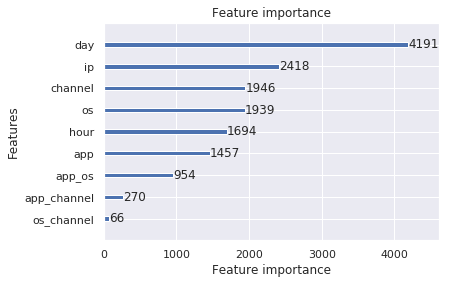

In [0]:
lgb.plot_importance(lgb_model, importance_type='split')
gc.collect()

3336

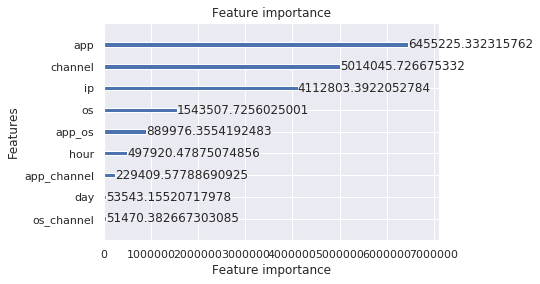

In [0]:
lgb.plot_importance(lgb_model, importance_type='gain')
gc.collect()

# Creating "rare" category

The interaction features seem to not do well. I'm wondering if it's because there are so many categories with very few clicks. Going to try to combine these into a "rare" category

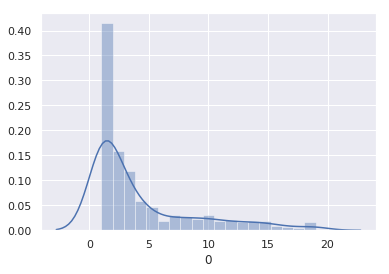

In [0]:
app_channel = double_counts[6]
sns.distplot(app_channel[0][app_channel[0]<20])

I'm wondering if categorizing all of the values with count of <5 together in a group that represents "rare" would help with use of these indicators. I'm still going to leave out all of the interaction features that include device feature.

I had originally tried to replace counts <5 with "rare" but lgb had trouble encoding string as categorical. I replaced it with the value 1010101 instead

In [0]:
for counts in double_counts:
    col_name=counts.columns.values[0]+'_'+counts.columns.values[1]
    counts[col_name]=counts[counts.columns.values[0]].map(str)+'_'+counts[counts.columns.values[1]].map(str)
    rare=counts.loc[counts[0]<5, col_name]
    train.loc[train[col_name].isin(rare), col_name]=1010101
    
for counts in double_counts:
    col_name=counts.columns.values[0]+'_'+counts.columns.values[1]
    counts[col_name]=counts[counts.columns.values[0]].map(str)+'_'+counts[counts.columns.values[1]].map(str)
    rare=counts.loc[counts[0]<5, col_name]
    val_data.loc[val_data[col_name].isin(rare), col_name]=1010101

In [0]:
#training model with popular parameters
target = 'is_attributed'

predictors = ['ip', 'app', 'os', 'channel', 'hour', 'day',
              'app_os', 'app_channel', 'os_channel']
categorical = ['ip', 'app', 'os', 'channel', 'hour', 'day',
              'app_os', 'app_channel', 'os_channel']

dtrain = lgb.Dataset(train[predictors].values, label=train[target].values,
                      feature_name=predictors,
                      categorical_feature=categorical
                      )
dvalid = lgb.Dataset(val_data[predictors].values, label=val_data[target].values,
                      feature_name=predictors,
                      categorical_feature=categorical
                      )

evals_results = {}

lgb_model = lgb.train(params, 
                 dtrain, 
                 valid_sets=[dtrain, dvalid], 
                 valid_names=['train','valid'], 
                 evals_result=evals_results, 
                 num_boost_round=350,
                 early_stopping_rounds=30,
                 verbose_eval=True, 
                 feval=None)

/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[1]	train's auc: 0.937533	valid's auc: 0.924279
Training until validation scores don't improve for 30 rounds.
[2]	train's auc: 0.952968	valid's auc: 0.950003
[3]	train's auc: 0.954239	valid's auc: 0.951427
[4]	train's auc: 0.957616	valid's auc: 0.953705
[5]	train's auc: 0.960246	valid's auc: 0.955994
[6]	train's auc: 0.961355	valid's auc: 0.957091
[7]	train's auc: 0.9617	valid's auc: 0.957428
[8]	train's auc: 0.96189	valid's auc: 0.957656
[9]	train's auc: 0.962397	valid's auc: 0.958515
[10]	train's auc: 0.963044	valid's auc: 0.959188
[11]	train's auc: 0.963376	valid's auc: 0.959637
[12]	train's auc: 0.963787	valid's auc: 0.960102
[13]	train's auc: 0.963848	valid's auc: 0.960139
[14]	train's auc: 0.963885	valid's auc: 0.960169
[15]	train's auc: 0.963792	valid's auc: 0.960117
[16]	train's auc: 0.963827	valid's auc: 0.960084
[17]	train's auc: 0.964218	valid's auc: 0.960492
[18]	train's auc: 0.964626	valid's auc: 0.960969
[19]	train's auc: 0.964993	valid's auc: 0.961276
[20]	train's auc: 0

235

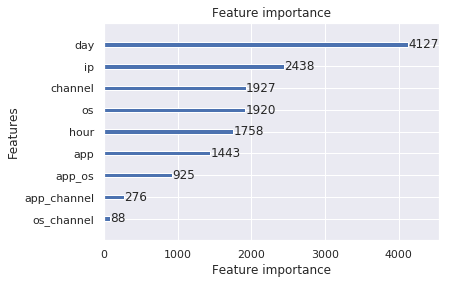

In [0]:
lgb.plot_importance(lgb_model, importance_type='split')
gc.collect()

2855

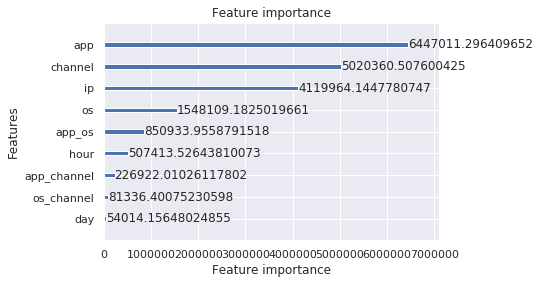

In [0]:
lgb.plot_importance(lgb_model, importance_type='gain')
gc.collect()

That still didn't help. Going to leave the interaction terms out for now. 